# Exercise 1a
#### Lars Kühmichel, Ergin Kohen Sagner, Nico Wolf

## 1 Monte-Carlo Simulation
### Inverse Transform Sampling
For $Y = 1$, it holds that $P(X = x) = 2x$. The CDF for $P$ is given as
$CDF(X \leq x) = \int_0^x 2x' \,dx' = x^2$.
With Inverse Transform Sampling, $X$ is then given by $CDF^{-1}(u) = \sqrt{u}$ where $u$ is
sampled from a uniform distribution in the interval $[0, 1]$.

For $Y = 0$, it holds that $P(x = x) = 2 - 2x$. The CDF for $P$ is then
$CDF(X \leq x) = \int_0^x 2 - 2x' \, dx' = 2x - x^2$. Analogously, $X$ is then given by $1 - \sqrt{1 - u}$.

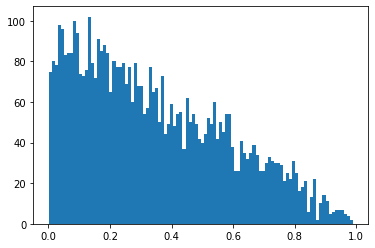

In [16]:
import numpy as np
from matplotlib import pyplot as plt


def create_data(N):
    # randint is high exclusive
    labels = np.random.randint(0, 2, size=N).astype(bool)

    features = np.random.uniform(0, 1, size=N)
    features = np.where(labels, np.sqrt(features), 1 - np.sqrt(1 - features))

    return features, labels

x, y = create_data(10000)

# verify x and y are created correctly
x = x[~y]

plt.hist(x, bins=100)
plt.show()
